In [1]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt

# Other
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading

import multiprocessing

import warnings
warnings.filterwarnings("ignore", message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.")

##############
from noisyopt import minimizeSPSA

In [2]:
import vqe_functions as vqe

## VQE

In [3]:
N = 4
J = 1
l_steps = 100
shift_invariance = 0

lams = np.linspace(0,2*J,l_steps)

step_size = 0.05
epochs = 250
shift_invariance = 0

In [6]:
dev_vqe_default = qml.device('default.qubit', wires = N, shots = None)
dev_vqe_mixed   = qml.device("default.mixed", wires = N, shots = None)

In [7]:
@qml.qnode(dev_vqe_default)
def vqe_cost_fn_default(vqe_params, N, shift_invariance, H):
    vqe.circuit(N, vqe_params, shift_invariance)
        
    # return <psi|H|psi>
    return qml.expval(H)

@qml.qnode(dev_vqe_mixed)
def vqe_cost_fn_mixed(vqe_params, N, shift_invariance, H, p_noise = 0, p_noise_ent = 0):
    vqe.circuit(N, vqe_params, shift_invariance, p_noise, p_noise_ent)
        
    # return <psi|H|psi>
    return qml.expval(H)


### VQE on noiseless Circuit

***Parameters:***

step_size    = 0.05 (Step size of the optimizer)
n_epochs     = 250 (# epochs for the other GSs
N            = 4 (Number of spins of the system)


***Circuit:***

0: ──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)─┤ ╰<𝓗>

Preparing states:


  0%|          | 0/34 [00:00<?, ?it/s]

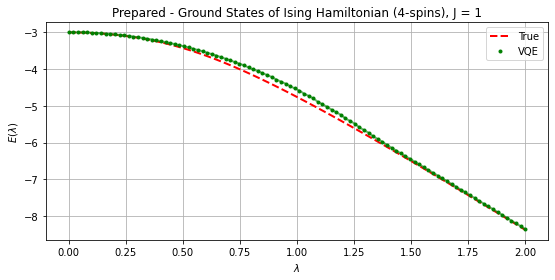

  0%|          | 0/250 [00:00<?, ?it/s]

/home/saverio/anaconda3/envs/qua/lib/python3.10/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


['./vqe_params_0noise.job']

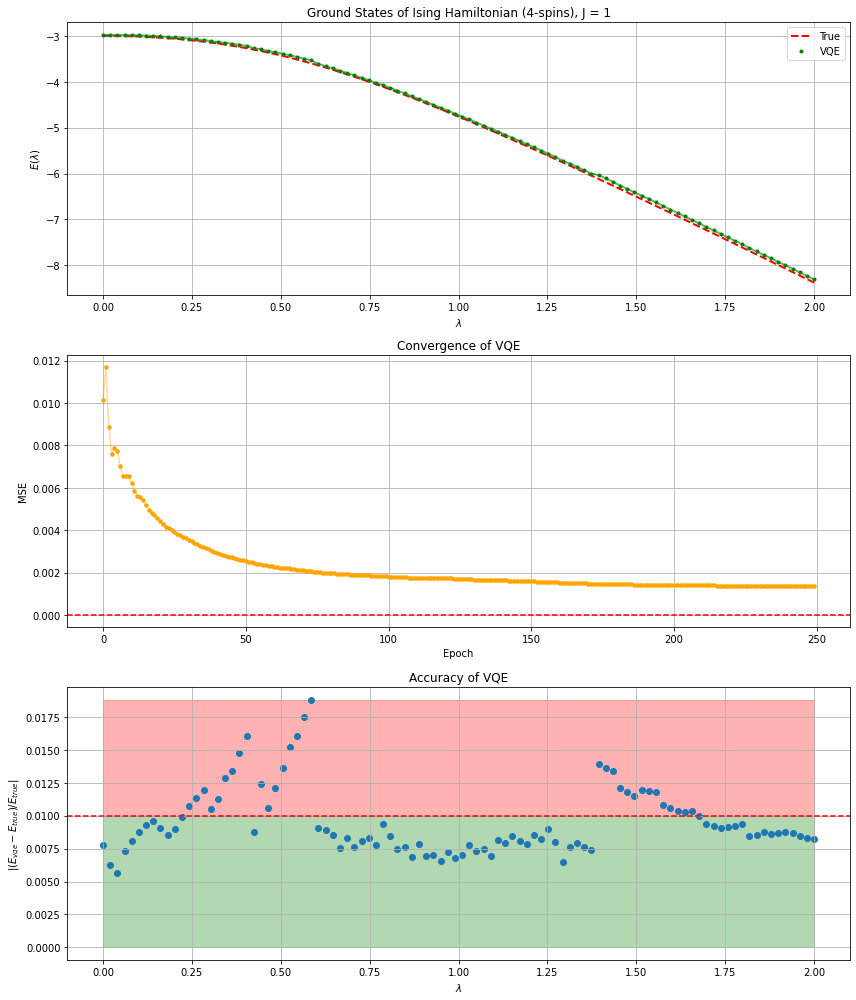

In [8]:
vqe_e, errs, thetas, ys = vqe.mp_train(step_size, lams, epochs, N, J, vqe_cost_fn_mixed, 
                                             shift_invariance = shift_invariance, p_noise = 0, p_noise_ent = 0,
                                             circuit = True, plots = True, prepare_states = True, preplots = True,
                                             prep_step_size = 0.05)

vqe_data_x = thetas 
vqe_data_y = ys
    
vqe_data = []
for i in range(len(vqe_data_x)):
    vqe_data.append((vqe_data_x[i],vqe_data_y[i]))
    
vqe_data = np.array(vqe_data)

joblib.dump(vqe_data, './vqe_params_0noise.job')


### VQE on noisy Circuit

In [22]:
N = 4
J = 1
l_steps = 10
shift_invariance = 0

lams = np.linspace(0,2*J,l_steps)

step_size = 0.25
epochs = 100
shift_invariance = 0

***Parameters:***

step_size    = 0.25 (Step size of the optimizer)
n_epochs     = 100 (# epochs for the other GSs
N            = 4 (Number of spins of the system)


***Circuit:***

0: ──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)─┤ ╰<𝓗>

Preparing states:


  0%|          | 0/10 [00:00<?, ?it/s]

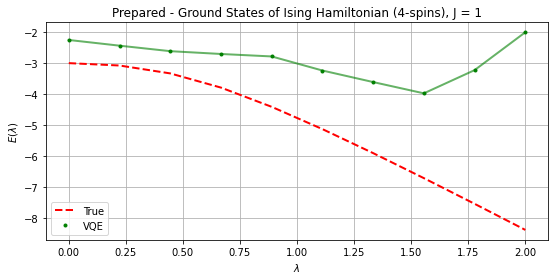

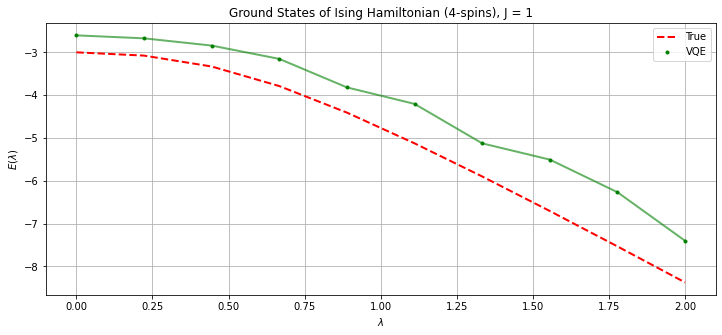

In [25]:
mp_train_SPSA(step_size, lams, epochs, N, J, vqe_cost_fn_mixed, 
                                             shift_invariance = shift_invariance, p_noise = 0.005, p_noise_ent = 0.005,
                                             circuit = True, plots = True, prepare_states = True, preplots = True,
                                             prep_step_size = 0.3)

# vqe_data_x = thetas 
# vqe_data_y = ys
#     
# vqe_data = []
# for i in range(len(vqe_data_x)):
#     vqe_data.append((vqe_data_x[i],vqe_data_y[i]))
#     
# vqe_data = np.array(vqe_data)
# 
# joblib.dump(vqe_data, './vqe_params_0.005noise.job')
# 

In [9]:
def qml_build_H(N, lam, J):
    '''
    Set up Hamiltonian: 
            H = lam*Σsigma^i_z - J*Σsigma^i_x*sigma^{i+1}_ 
    '''
    # Interaction of spins with magnetic field
    H = lam * qml.PauliZ(0)
    for i in range(1,N):
        H = H + lam * qml.PauliZ(i)
        
    # Interaction between spins:
    for i in range(0,N-1):
        H = H + J*(-1)*( qml.PauliX(i) @ qml.PauliX(i+1) )
    
    return H

In [11]:
def mp_update_params(idx, params, N, shift_invariance, vqe_cost_fn, opts, Hs, true_e, p_noise, p_noise_ent):
    '''
    Update function to be called inside the training function
    idx              = index to update: idx in range(len(lambdas))
    N                = number of wires/spin
    shift_invariance = type of circuit
    opts             = array of optimizers
    Hs               = array of Hamiltonians
    p_noise          = noise after R-gates
    p_noise_ent      = noise after entanglements
    '''
    param = params[idx]
    H = Hs[idx]
    opt = opts[idx]

    cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, H, p_noise, p_noise_ent)
    param_next, energy = opt.step_and_cost(cost_fn, param)

    return param_next, opt, (energy - true_e[idx] )**2

def mp_train(step_size, lams, n_epochs, N, J, vqe_cost_fn, shift_invariance = 0, p_noise = 0, p_noise_ent = 0, circuit = False, plots = False,
             prepare_states = False, preplots = False, prep_step_size = False, cutoff_value = 0.01):
    
    # define the wrapper update function to be called inside a multiprocessing map 
    # as a global variable to avoid the pickle error with the Jupyter Kernel
    global wrapped_update
    
    '''
    n_epochs     = # epochs for the other lambdas
    lams         = Array of intensities of magnetic field
    N            = Number of spins of the system
    '''
    
    display(Markdown('***Parameters:***'))
    print('step_size    = {0} (Step size of the optimizer)'.format(step_size))
    print('n_epochs     = {0} (# epochs for the other GSs'.format(n_epochs))
    print('N            = {0} (Number of spins of the system)'.format(N))
    
    # Since we are parallelizing the VQE algorithm we cannot recycle the previous parameter for the next lambda
    if shift_invariance == 0:
        n_params = 5*N
    elif shift_invariance == 1:
        n_params = 20
    elif shift_invariance == 2:
        n_params = 5
    
    # Prepare initial parameters randomly for each datapoint/state
    params = []

    for _ in lams:
        param = np.random.rand(n_params)
        params.append(param)
        
    if circuit:
        # Display the circuit
        display(Markdown('***Circuit:***'))
        drawer = qml.draw(vqe_cost_fn)
        print(drawer([0]*100, N, shift_invariance, H = qml_build_H(N, 0 ,0)))
    
    # For each lamda create optimizer and H
    Hs   = []
    opts = []
    energy_err  = [0]*(len(lams))
    MSE = []
    true_e = []
    
    for i, lam in enumerate(lams):
        Hs.append(qml_build_H(N, float(lam), float(J) ))
        opts.append(qml.AdamOptimizer(stepsize=step_size))
        true_e.append(np.min(qml.eigvals(Hs[i])) )
    
    # STATES PREPARATION:
    # Preparing initial parameters recycling thetas
    
    # If pre_step_size is left as false we set it
    # as step_size
    if not prep_step_size:
        prep_step_size = step_size
        
    if prepare_states:
        print('\nPreparing states:')
        
        # We prepare the states of every 3 parameters, the others are copied from the 
        # previous ones
        prep_progress = tqdm(np.arange(0, len(lams), 3))
        
        for prep_l in prep_progress:
            if prep_l == 0:
                prep_params = params[0]
            else:
                prep_params = params[prep_l - 1]
            
            opt = qml.AdamOptimizer(stepsize=prep_step_size)
            H = qml_build_H(N, float(lams[prep_l]), J)
            cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, H, p_noise, p_noise_ent)
            
            # The first one is given more epochs being the one starting
            # from totally random parameters
            prep_epochs = 50 if prep_l == 0 else 2
            
            # Actual VQE algorithm for a datapoint/state
            for epoch in range(prep_epochs):
                prep_params, _ = opt.step_and_cost(cost_fn, prep_params)
                
            params[prep_l] = prep_params
            # The following two are copied of the state just found
            if prep_l+1 < len(lams): params[prep_l+1] = prep_params
            if prep_l+2 < len(lams): params[prep_l+2] = prep_params
        
        # The VQE performance can be plotted to see how close to the result
        # it is before the actual training
        if preplots:
            fig, ax = plt.subplots(1, 1, figsize=(9,4))
            vqe_e  = []
            for i, lam in enumerate(lams):
                cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, Hs[i], p_noise, p_noise_ent)
                vqe_e.append(cost_fn(params[i]) )

            ax.plot(lams, true_e, '--', label='True', color='red', lw = 2)
            ax.plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
            ax.plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
            ax.grid(True)
            ax.set_title('Prepared - Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
            ax.set_xlabel(r'$\lambda$')
            ax.set_ylabel(r'$E(\lambda)$')
            ax.legend()
            
            plt.show()
        
    progress = tqdm(range(n_epochs))
    
    # IDEA in active_points:
    #   train only the datapoints/states that 
    #   have a relative error greater than CUTOFF
    active_points = np.arange(len(lams))
    
    for epoch in progress:
        # In the happy scenario all points have a relative error below CUTOFF
        # we can just stop the training aswell
        if len(active_points) == 0:
            n_epochs = epoch - 1
            break
        
        def wrapped_update(idx):
            return mp_update_params(idx, params, N, shift_invariance, vqe_cost_fn, opts, Hs, true_e, p_noise, p_noise_ent)
        
        p = multiprocessing.Pool()
        with p: rdata = p.map(wrapped_update, active_points)
        
        cutoffs = [] # Array of the new datapoints that have a relative error below CUTOFF
        for k, l in enumerate(active_points):
            params[l], opts[l], energy_err[l] = rdata[k]
            
            if np.sqrt(energy_err[l])/np.abs(true_e[l]) < cutoff_value:
                cutoffs.append(l)
                
        # Remove all the datapoints from active_points contained in cutoff
        for cutoff in cutoffs:
            active_points = np.delete(active_points, np.where(active_points == cutoff))
        
        # Not actually the MSE since it is computed on just the active_points
        MSE.append(np.mean(energy_err))
        
        progress.set_description('Cost: {0}'.format(MSE[-1]) )
    
    vqe_e  = []
    for i, lam in enumerate(lams):
        cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, Hs[i], p_noise, p_noise_ent)
        vqe_e.append(cost_fn(params[i]) )
    
    if plots:
        fig, ax = plt.subplots(3, 1, figsize=(12,14))
                          
        ax[0].plot(lams, true_e, '--', label='True', color='red', lw = 2)
        ax[0].plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
        ax[0].plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
        ax[0].grid(True)
        ax[0].set_title('Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
        ax[0].set_xlabel(r'$\lambda$')
        ax[0].set_ylabel(r'$E(\lambda)$')
        ax[0].legend()
        
        ax[1].plot(range(n_epochs), MSE, '.', color='orange', ms = 7 )
        ax[1].plot(range(n_epochs), MSE, color='orange', alpha=0.4)
        ax[1].set_title('Convergence of VQE')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('MSE')
        ax[1].grid(True)
        ax[1].axhline(y=0, color='r', linestyle='--')
        
        true_e = np.array(true_e)
        vqe_e = np.array(vqe_e)
        accuracy = np.abs((true_e-vqe_e)/true_e)
        ax[2].fill_between(lams, 0.01, max(np.max(accuracy),0.01), color = 'r', alpha = 0.3 )
        ax[2].fill_between(lams, .01, min(np.min(accuracy),0), color = 'green', alpha = 0.3 )
        ax[2].axhline(y=0.01, color='r', linestyle='--')
        ax[2].scatter(lams, accuracy)
        ax[2].grid(True)
        ax[2].set_title('Accuracy of VQE'.format(N,J))
        ax[2].set_xlabel(r'$\lambda$')
        ax[2].set_ylabel(r'$|(E_{vqe} - E_{true})/E_{true}|$')
        
        plt.tight_layout()
    
    ys = []
    for l in lams:
        ys.append(0) if l <= J else ys.append(1)
        
    return vqe_e, MSE, params, ys

In [24]:
def mp_train_param_SPSA(idx, params, N, shift_invariance, vqe_cost_fn, Hs, true_e, p_noise, p_noise_ent, epochs):
    param = params[idx]
    H = Hs[idx]
    cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, H, p_noise, p_noise_ent)
    
    res = minimizeSPSA(cost_fn,
                       x0=param,
                       niter=epochs,
                       paired=False,
                       c=0.15,
                       a=0.2)

    return res.x

def mp_train_SPSA(step_size, lams, n_epochs, N, J, vqe_cost_fn, shift_invariance = 0, p_noise = 0, p_noise_ent = 0, circuit = False, plots = False,
                  prepare_states = False, preplots = False, prep_step_size = False, cutoff_value = 0.01):
    
    # define the wrapper update function to be called inside a multiprocessing map 
    # as a global variable to avoid the pickle error with the Jupyter Kernel
    global wrapped_update
    
    '''
    n_epochs     = # epochs for the other lambdas
    lams         = Array of intensities of magnetic field
    N            = Number of spins of the system
    '''
    
    display(Markdown('***Parameters:***'))
    print('step_size    = {0} (Step size of the optimizer)'.format(step_size))
    print('n_epochs     = {0} (# epochs for the other GSs'.format(n_epochs))
    print('N            = {0} (Number of spins of the system)'.format(N))
    
    # Since we are parallelizing the VQE algorithm we cannot recycle the previous parameter for the next lambda
    if shift_invariance == 0:
        n_params = 5*N
    elif shift_invariance == 1:
        n_params = 20
    elif shift_invariance == 2:
        n_params = 5
    
    # Prepare initial parameters randomly for each datapoint/state
    params = []

    for _ in lams:
        param = np.random.rand(n_params)
        params.append(param)
        
    if circuit:
        # Display the circuit
        display(Markdown('***Circuit:***'))
        drawer = qml.draw(vqe_cost_fn)
        print(drawer([0]*100, N, shift_invariance, H = qml_build_H(N, 0 ,0)))
    
    # For each lamda create optimizer and H
    Hs   = []
    opts = []
    energy_err  = [0]*(len(lams))
    MSE = []
    true_e = []
    
    for i, lam in enumerate(lams):
        Hs.append(qml_build_H(N, float(lam), float(J) ))
        true_e.append(np.min(qml.eigvals(Hs[i])) )
    
    # STATES PREPARATION:
    # Preparing initial parameters recycling thetas
    
    # If pre_step_size is left as false we set it
    # as step_size
    if not prep_step_size:
        prep_step_size = step_size
        
    if prepare_states:
        print('\nPreparing states:')
        
        # We prepare the states of every 3 parameters, the others are copied from the 
        # previous ones
        prep_progress = tqdm(np.arange(0, len(lams), 1))
        
        for prep_l in prep_progress:
            if prep_l == 0:
                prep_params = params[0]
            else:
                prep_params = params[prep_l - 1]
            
            opt = qml.AdamOptimizer(stepsize=prep_step_size)
            H = qml_build_H(N, float(lams[prep_l]), J)
            cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, H, p_noise, p_noise_ent)
            
            # The first one is given more epochs being the one starting
            # from totally random parameters
            prep_epochs = 50 if prep_l == 0 else 10
            
            res = minimizeSPSA(cost_fn,
                               x0=prep_params,
                               niter=prep_epochs,
                               paired=False,
                               c=0.15,
                               a=0.2)
            params[prep_l] = res.x
                               
        # The VQE performance can be plotted to see how close to the result
        # it is before the actual training
        if preplots:
            fig, ax = plt.subplots(1, 1, figsize=(9,4))
            vqe_e  = []
            for i, lam in enumerate(lams):
                cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, Hs[i], p_noise, p_noise_ent)
                vqe_e.append(cost_fn(params[i]) )

            ax.plot(lams, true_e, '--', label='True', color='red', lw = 2)
            ax.plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
            ax.plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
            ax.grid(True)
            ax.set_title('Prepared - Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
            ax.set_xlabel(r'$\lambda$')
            ax.set_ylabel(r'$E(\lambda)$')
            ax.legend()
            
            plt.show()
            
    def wrapped_update(idx):
        return mp_train_param_SPSA(idx, params, N, shift_invariance, vqe_cost_fn, Hs, true_e, p_noise, p_noise_ent, n_epochs)

    p = multiprocessing.Pool()
    with p: rdata = p.map(wrapped_update, np.arange(len(lams)) )
        
    vqe_e = []
    for l, lam in enumerate(lams):
        params[l] = rdata[l]
        cost_fn = lambda v: vqe_cost_fn(v, N, shift_invariance, Hs[l], p_noise, p_noise_ent)
        vqe_e.append(cost_fn(params[l]) )
    
    if plots:
        fig, ax = plt.subplots(1, 1, figsize=(12,5))
                          
        ax.plot(lams, true_e, '--', label='True', color='red', lw = 2)
        ax.plot(lams, vqe_e, '.', label='VQE', color='green', lw = 2)
        ax.plot(lams, vqe_e, color='green', lw = 2, alpha=0.6)
        ax.grid(True)
        ax.set_title('Ground States of Ising Hamiltonian ({0}-spins), J = {1}'.format(N,J))
        ax.set_xlabel(r'$\lambda$')
        ax.set_ylabel(r'$E(\lambda)$')
        ax.legend()